In [2]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
TRAIN_DIR = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train"
TEST_DIR  = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test"

In [6]:
tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [7]:

full_train = ImageFolder(TRAIN_DIR, transform= tf)
full_val   = ImageFolder(TRAIN_DIR, transform= tf)
test_ds  = ImageFolder(TEST_DIR,  transform= tf)

indices = list(range(len(full_train)))
labels  = full_train.targets


train_idx, val_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)


train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(val_idx)


train_loader = DataLoader(full_train, batch_size=64, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(full_val,   batch_size=64, sampler=val_sampler,   num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples:   {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples:   6515
Validation samples: 1629
Test samples: 8041


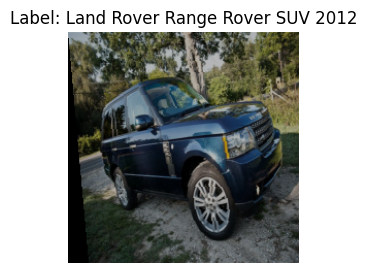

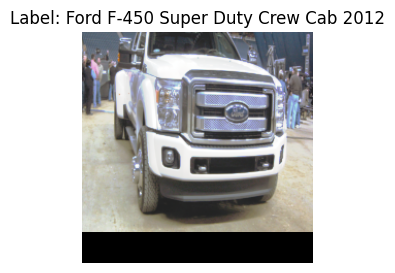

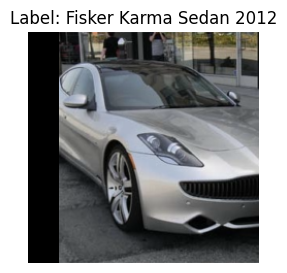

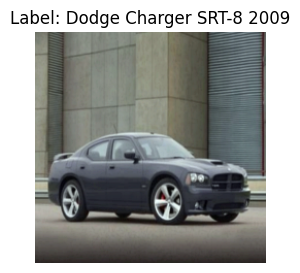

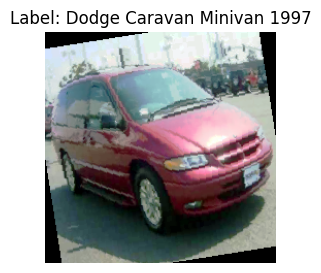

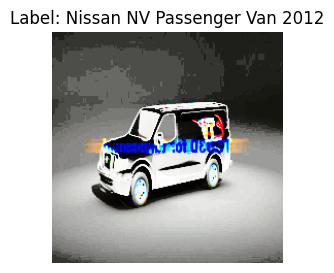

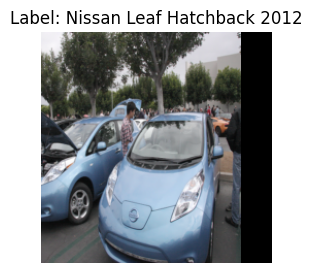

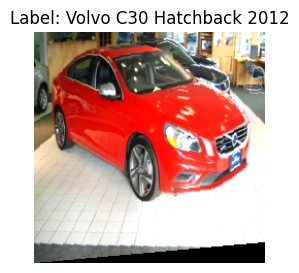

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(loader, num_images=8):
    """
    Display `num_images` samples from the given DataLoader.
    """
    images, labels = next(iter(loader))
    # Unnormalize parameters (assuming ImageNet normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    for idx in range(min(num_images, len(images))):
        img = images[idx].cpu().permute(1, 2, 0).numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.figure(figsize=(3,3))
        plt.imshow(img)
        plt.title(f"Label: {loader.dataset.classes[labels[idx]]}")
        plt.axis('off')
        plt.show()

show_samples(train_loader, num_images=8)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(full_train.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [8]:
# Containers for metrics
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_top5_accs = []

# Training loop with validation
for epoch in range(1, epochs+1):
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds==y).sum().item()
        total += x.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    top5_correct = 0
    with torch.no_grad():
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Val]"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds==y).sum().item()
            val_total += x.size(0)
            # Top-5 accuracy
            top5 = torch.topk(logits, k=5, dim=1).indices
            top5_correct += sum([1 if y[i] in top5[i] else 0 for i in range(y.size(0))])
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    top5_acc = top5_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_top5_accs.append(top5_acc)

    scheduler.step()
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, Top-5 Acc={top5_acc:.4f}")

Epoch 1/10 [Val]: 100%|██████████| 102/102 [00:29<00:00,  3.42it/s]


Epoch 1: Train Loss=4.7640, Acc=0.0597 | Val Loss=2.8843, Acc=0.3299, Top-5 Acc=0.6410


Epoch 2/10 [Val]: 100%|██████████| 102/102 [00:29<00:00,  3.48it/s]


Epoch 2: Train Loss=2.1399, Acc=0.4724 | Val Loss=0.9197, Acc=0.7742, Top-5 Acc=0.9518


Epoch 3/10 [Val]: 100%|██████████| 102/102 [00:29<00:00,  3.42it/s]


Epoch 3: Train Loss=0.9749, Acc=0.7484 | Val Loss=0.4564, Acc=0.8827, Top-5 Acc=0.9900


Epoch 4/10 [Val]: 100%|██████████| 102/102 [00:29<00:00,  3.43it/s]


Epoch 4: Train Loss=0.5591, Acc=0.8622 | Val Loss=0.2597, Acc=0.9389, Top-5 Acc=0.9965


Epoch 5/10 [Val]: 100%|██████████| 102/102 [00:29<00:00,  3.46it/s]


Epoch 5: Train Loss=0.3565, Acc=0.9206 | Val Loss=0.1454, Acc=0.9645, Top-5 Acc=0.9986


Epoch 6/10 [Val]: 100%|██████████| 102/102 [00:29<00:00,  3.41it/s]


Epoch 6: Train Loss=0.2516, Acc=0.9500 | Val Loss=0.0844, Acc=0.9845, Top-5 Acc=0.9998


Epoch 7/10 [Val]: 100%|██████████| 102/102 [00:29<00:00,  3.41it/s]


Epoch 7: Train Loss=0.1786, Acc=0.9676 | Val Loss=0.0615, Acc=0.9894, Top-5 Acc=0.9997


Epoch 8/10 [Val]: 100%|██████████| 102/102 [00:30<00:00,  3.37it/s]


Epoch 8: Train Loss=0.1374, Acc=0.9777 | Val Loss=0.0508, Acc=0.9903, Top-5 Acc=0.9997


Epoch 9/10 [Val]: 100%|██████████| 102/102 [00:30<00:00,  3.33it/s]


Epoch 9: Train Loss=0.1232, Acc=0.9808 | Val Loss=0.0420, Acc=0.9928, Top-5 Acc=0.9998


Epoch 10/10 [Val]: 100%|██████████| 102/102 [00:30<00:00,  3.40it/s]

Epoch 10: Train Loss=0.1182, Acc=0.9823 | Val Loss=0.0373, Acc=0.9943, Top-5 Acc=0.9998


In [9]:
# Plot Loss and Accuracy curves
fig, axs = plt.subplots(1, 2, figsize=(14,5))
# Loss
axs[0].plot(range(1, epochs+1), train_losses, label='Train Loss')
axs[0].plot(range(1, epochs+1), val_losses,   label='Val Loss')
axs[0].set_title('Loss Curves')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Accuracy
axs[1].plot(range(1, epochs+1), train_accs,     label='Train Acc')
axs[1].plot(range(1, epochs+1), val_accs,       label='Val Acc')
axs[1].plot(range(1, epochs+1), val_top5_accs,  label='Val Top-5 Acc')
axs[1].set_title('Accuracy Curves')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.show()


In [14]:
model.eval()
all_trues, all_preds = [], []
all_logits = []
with torch.no_grad():
    for xb,yb in tqdm(test_loader, desc="Test Eval"):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(1)
        all_trues.extend(yb.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_logits.append(logits.cpu())
all_logits = torch.cat(all_logits)
# metrics
test_acc  = accuracy_score(all_trues, all_preds)
test_prec = precision_score(all_trues, all_preds, average='macro')
test_rec  = recall_score(all_trues, all_preds, average='macro')
report    = classification_report(all_trues, all_preds, target_names=full_train.classes, digits=4)
cm        = confusion_matrix(all_trues, all_preds, normalize='true')
# top-5
top5 = torch.topk(all_logits,5,dim=1).indices
test_top5 = (top5 == torch.tensor(all_trues).unsqueeze(1)).any(dim=1).float().mean().item()

print(f"\nTest Accuracy : {test_acc*100:.2f}%")
print(f"Macro Precision: {test_prec*100:.2f}%")
print(f"Macro Recall  : {test_rec*100:.2f}%")
print(f"Test Top-5 Acc: {test_top5*100:.2f}%\n")
print("Classification Report:\n", report)

Test Eval: 100%|██████████| 126/126 [00:36<00:00,  3.42it/s]



Test Accuracy : 84.39%
Macro Precision: 84.83%
Macro Recall  : 84.40%
Test Top-5 Acc: 96.84%

Classification Report:
                                                         precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.8776    0.9773    0.9247        44
                             Acura Integra Type R 2001     0.9211    0.7955    0.8537        44
                                   Acura RL Sedan 2012     0.7647    0.8125    0.7879        32
                                   Acura TL Sedan 2012     0.7660    0.8372    0.8000        43
                                  Acura TL Type-S 2008     0.9167    0.7857    0.8462        42
                                  Acura TSX Sedan 2012     0.8750    0.8750    0.8750        40
                              Acura ZDX Hatchback 2012     0.7143    0.7692    0.7407        39
              Aston Martin V8 Vantage Convertible 2012     0.8485    0.6222    0.7179        45
                

In [15]:

cm = confusion_matrix(all_trues, all_preds, normalize='true')
class_names = full_train.classes  

num_classes = len(class_names)
step = max(1, num_classes // 20)  

ticks = np.arange(0, num_classes, step)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, cmap='Blues', ax=ax, cbar_kws={'label':'Recall per class'})
ax.set_title("Normalized Confusion Matrix (thinned ticks)")

ax.set_xticks(ticks + 0.5)
ax.set_yticks(ticks + 0.5)
ax.set_xticklabels([class_names[i] for i in ticks], rotation=90, fontsize=8)
ax.set_yticklabels([class_names[i] for i in ticks], rotation=0, fontsize=8)
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
plt.tight_layout()
plt.show()

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

<module 'torch.nn' from '/usr/local/lib/python3.11/dist-packages/torch/nn/__init__.py'>

In [11]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, num_heads=8):
        super().__init__()
        self.embed_dim = in_channels
        self.num_heads = num_heads
        self.mha = nn.MultiheadAttention(
            embed_dim=in_channels, num_heads=num_heads, batch_first=True
        )
    def forward(self, x):
        # x: [B, C, H, W] -> [B, H*W, C]
        B, C, H, W = x.shape
        seq = x.view(B, C, H*W).permute(0, 2, 1)  # B, N, C
        attn_out, _ = self.mha(seq, seq, seq)
        # add & reshape
        out = attn_out.permute(0, 2, 1).view(B, C, H, W)
        return out + x  # residual

# 4) ResNet-50 + Self-Attention
from torchvision.models import resnet50
class ResNet50_SA(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        # inject self-attention after layer4
        in_ch = self.backbone.layer4[-1].conv3.out_channels
        self.sa = SelfAttention(in_ch, num_heads=8)
        # replace classifier head
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
    def forward(self, x):
        # standard ResNet layers until layer4
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        # self-attention
        x = self.sa(x)
        # pool & classify
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        return self.backbone.fc(x)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ResNet50_SA(num_classes=len(full_train.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [14]:
# Containers for metrics
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_top5_accs = []

# Training loop with validation
for epoch in range(1, epochs+1):
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds==y).sum().item()
        total += x.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    top5_correct = 0
    with torch.no_grad():
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Val]"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds==y).sum().item()
            val_total += x.size(0)
            # Top-5 accuracy
            top5 = torch.topk(logits, k=5, dim=1).indices
            top5_correct += sum([1 if y[i] in top5[i] else 0 for i in range(y.size(0))])
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    top5_acc = top5_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_top5_accs.append(top5_acc)

    scheduler.step()
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, Top-5 Acc={top5_acc:.4f}")

Epoch 1/10 [Val]: 100%|██████████| 102/102 [00:28<00:00,  3.57it/s]


Epoch 1: Train Loss=4.2876, Acc=0.1042 | Val Loss=3.0355, Acc=0.2421, Top-5 Acc=0.5624


Epoch 2/10 [Val]: 100%|██████████| 102/102 [00:28<00:00,  3.60it/s]


Epoch 2: Train Loss=2.2235, Acc=0.3991 | Val Loss=1.6510, Acc=0.5302, Top-5 Acc=0.8651


Epoch 3/10 [Val]: 100%|██████████| 102/102 [00:27<00:00,  3.65it/s]


Epoch 3: Train Loss=1.3020, Acc=0.6180 | Val Loss=1.0621, Acc=0.6767, Top-5 Acc=0.9361


Epoch 4/10 [Val]: 100%|██████████| 102/102 [00:27<00:00,  3.70it/s]


Epoch 4: Train Loss=0.8038, Acc=0.7550 | Val Loss=0.6086, Acc=0.8121, Top-5 Acc=0.9767


Epoch 5/10 [Val]: 100%|██████████| 102/102 [00:33<00:00,  3.07it/s]


Epoch 5: Train Loss=0.4738, Acc=0.8526 | Val Loss=0.3677, Acc=0.8809, Top-5 Acc=0.9906


Epoch 6/10 [Val]: 100%|██████████| 102/102 [00:34<00:00,  3.00it/s]


Epoch 6: Train Loss=0.2976, Acc=0.9050 | Val Loss=0.1946, Acc=0.9397, Top-5 Acc=0.9975


Epoch 7/10 [Val]: 100%|██████████| 102/102 [00:35<00:00,  2.90it/s]


Epoch 7: Train Loss=0.1733, Acc=0.9450 | Val Loss=0.1003, Acc=0.9704, Top-5 Acc=0.9992


Epoch 8/10 [Val]: 100%|██████████| 102/102 [00:35<00:00,  2.85it/s]


Epoch 8: Train Loss=0.1100, Acc=0.9665 | Val Loss=0.0710, Acc=0.9805, Top-5 Acc=0.9992


Epoch 9/10 [Val]: 100%|██████████| 102/102 [00:31<00:00,  3.26it/s]


Epoch 9: Train Loss=0.0705, Acc=0.9810 | Val Loss=0.0453, Acc=0.9877, Top-5 Acc=0.9998


Epoch 10/10 [Val]: 100%|██████████| 102/102 [00:29<00:00,  3.52it/s]

Epoch 10: Train Loss=0.0593, Acc=0.9842 | Val Loss=0.0453, Acc=0.9859, Top-5 Acc=0.9997


In [16]:
# Plot Loss and Accuracy curves
fig, axs = plt.subplots(1, 2, figsize=(14,5))
# Loss
axs[0].plot(range(1, epochs+1), train_losses, label='Train Loss')
axs[0].plot(range(1, epochs+1), val_losses,   label='Val Loss')
axs[0].set_title('Loss Curves')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Accuracy
axs[1].plot(range(1, epochs+1), train_accs,     label='Train Acc')
axs[1].plot(range(1, epochs+1), val_accs,       label='Val Acc')
axs[1].plot(range(1, epochs+1), val_top5_accs,  label='Val Top-5 Acc')
axs[1].set_title('Accuracy Curves')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.show()

In [17]:
model.eval()
all_trues, all_preds = [], []
all_logits = []
with torch.no_grad():
    for xb,yb in tqdm(test_loader, desc="Test Eval"):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(1)
        all_trues.extend(yb.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_logits.append(logits.cpu())
all_logits = torch.cat(all_logits)
# metrics
test_acc  = accuracy_score(all_trues, all_preds)
test_prec = precision_score(all_trues, all_preds, average='macro')
test_rec  = recall_score(all_trues, all_preds, average='macro')
report    = classification_report(all_trues, all_preds, target_names=full_train.classes, digits=4)
cm        = confusion_matrix(all_trues, all_preds, normalize='true')
# top-5
top5 = torch.topk(all_logits,5,dim=1).indices
test_top5 = (top5 == torch.tensor(all_trues).unsqueeze(1)).any(dim=1).float().mean().item()

print(f"\nTest Accuracy : {test_acc*100:.2f}%")
print(f"Macro Precision: {test_prec*100:.2f}%")
print(f"Macro Recall  : {test_rec*100:.2f}%")
print(f"Test Top-5 Acc: {test_top5*100:.2f}%\n")
print("Classification Report:\n", report)

Test Eval: 100%|██████████| 126/126 [00:55<00:00,  2.25it/s]



Test Accuracy : 80.87%
Macro Precision: 81.47%
Macro Recall  : 80.82%
Test Top-5 Acc: 95.95%

Classification Report:
                                                         precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.8723    0.9318    0.9011        44
                             Acura Integra Type R 2001     0.9444    0.7727    0.8500        44
                                   Acura RL Sedan 2012     0.5946    0.6875    0.6377        32
                                   Acura TL Sedan 2012     0.6667    0.7442    0.7033        43
                                  Acura TL Type-S 2008     0.7234    0.8095    0.7640        42
                                  Acura TSX Sedan 2012     0.7941    0.6750    0.7297        40
                              Acura ZDX Hatchback 2012     0.8000    0.8205    0.8101        39
              Aston Martin V8 Vantage Convertible 2012     0.6923    0.6000    0.6429        45
                

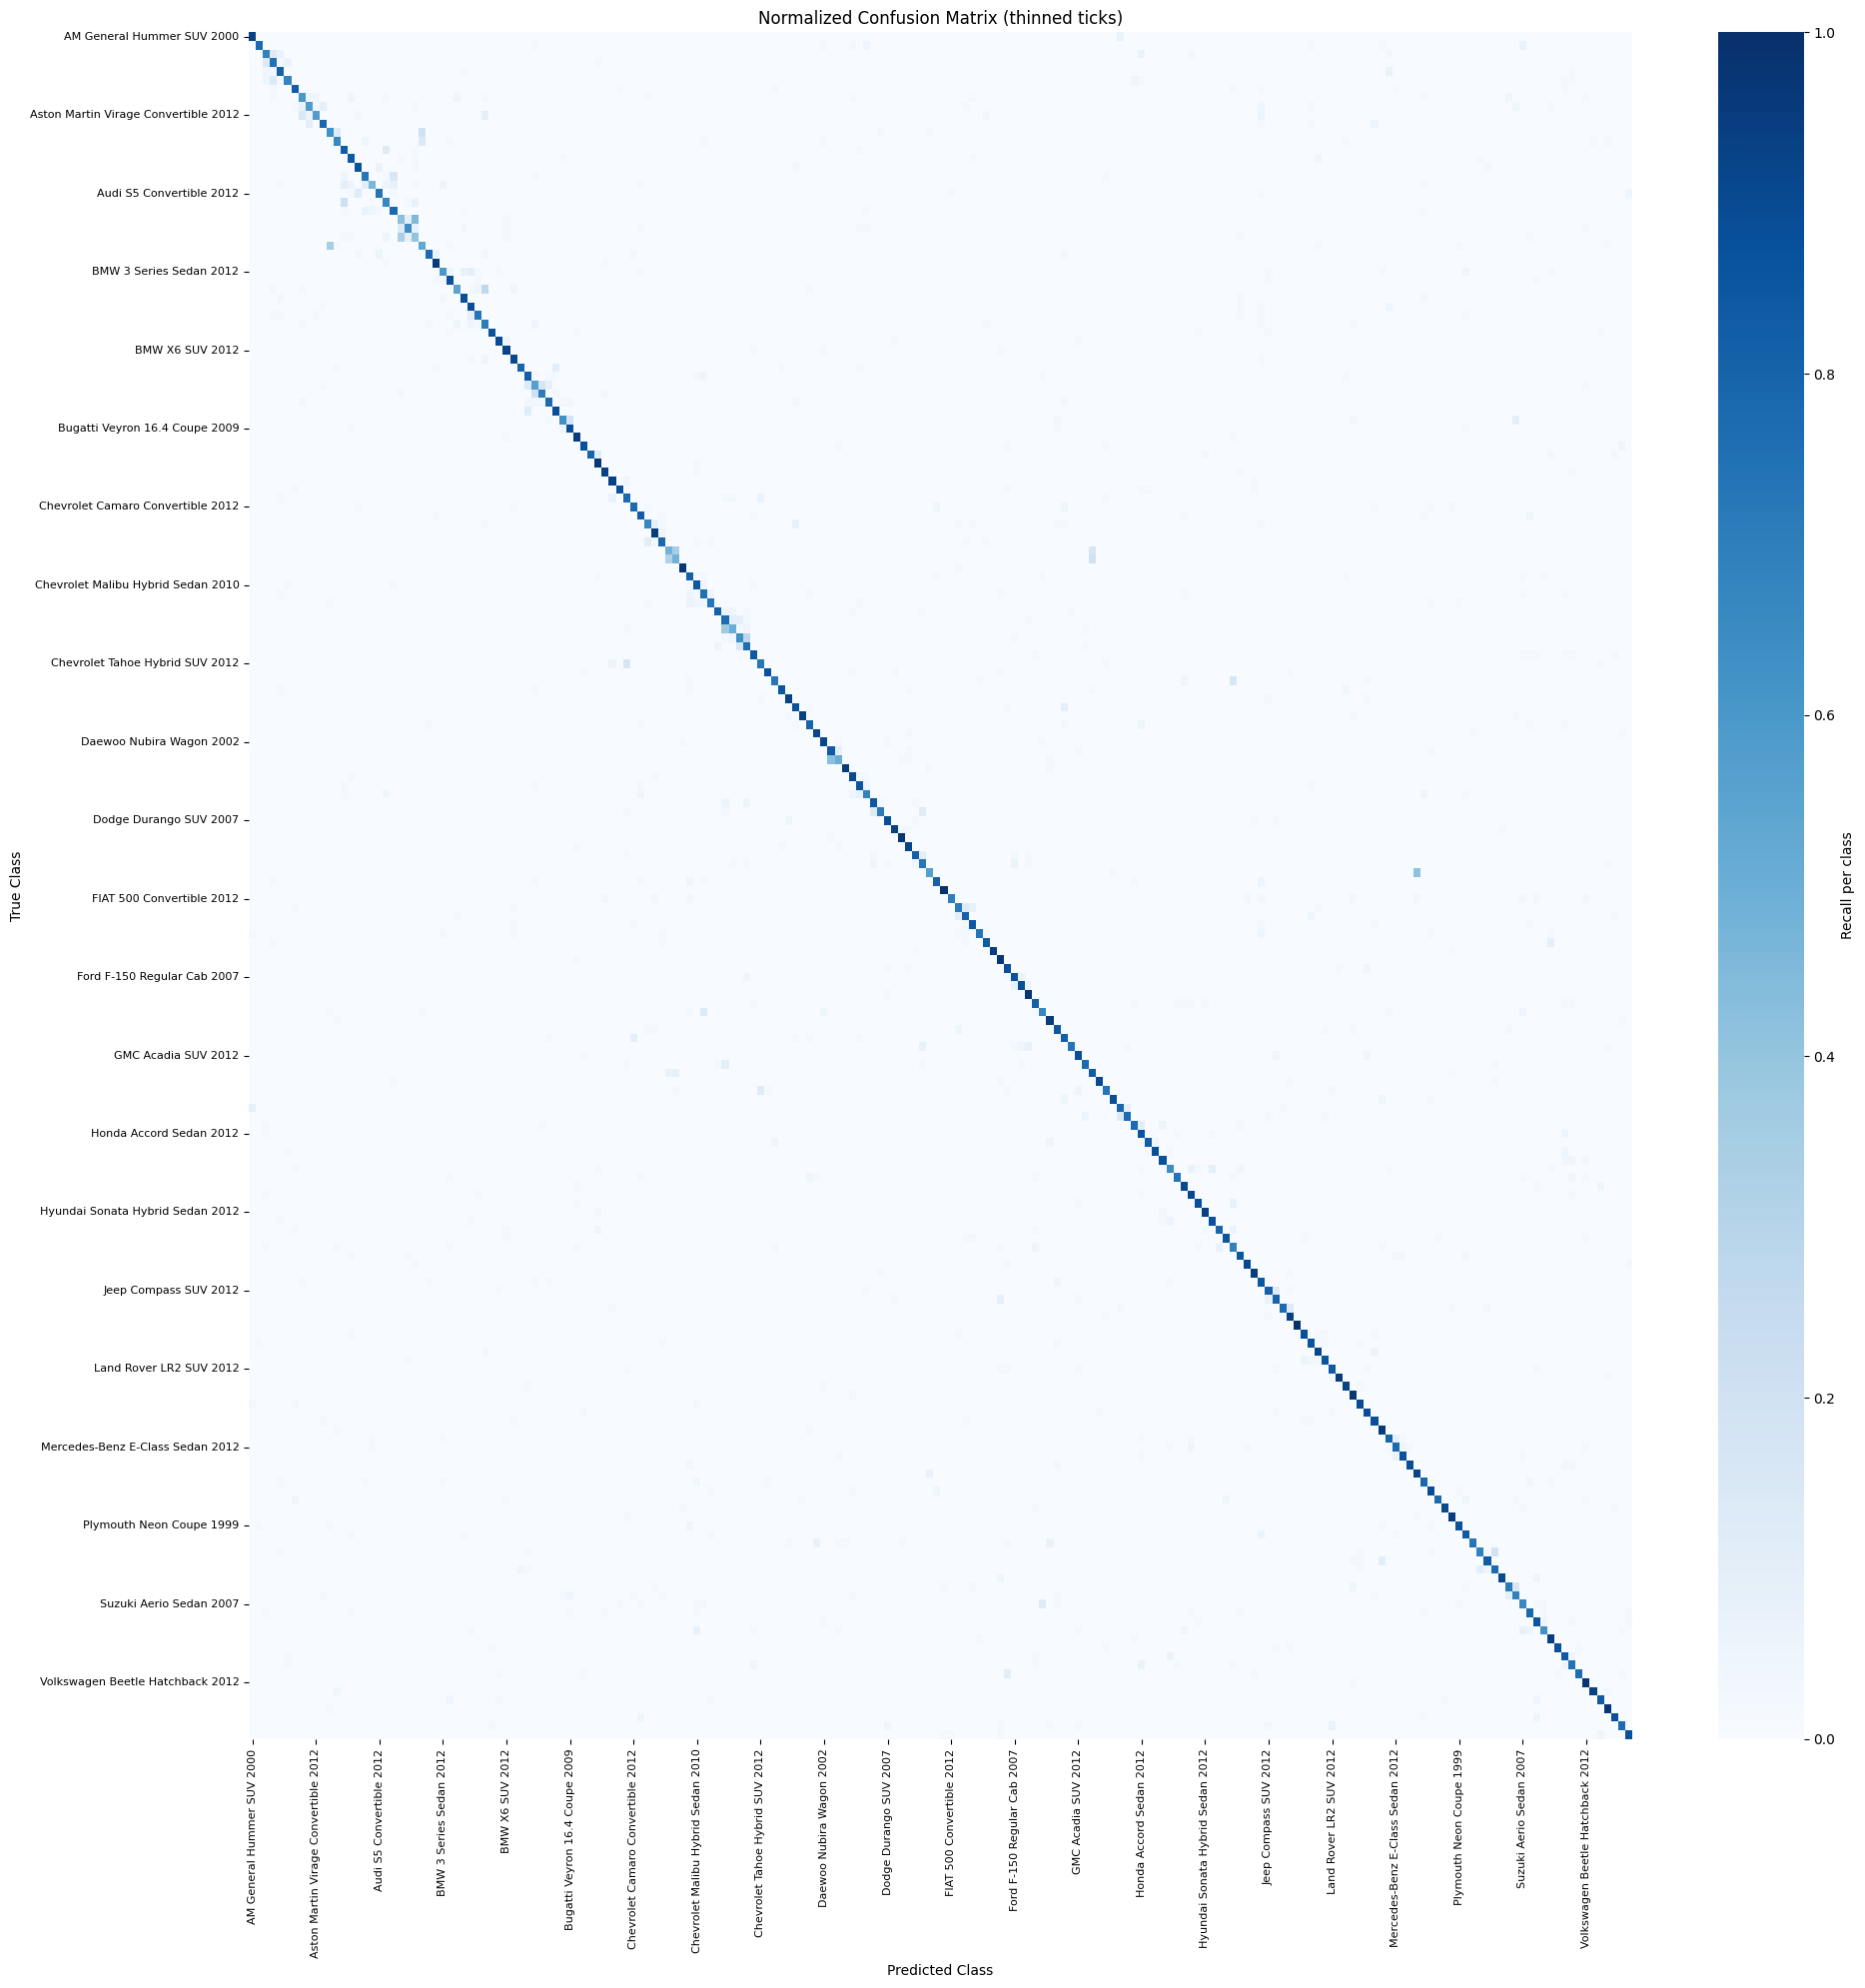

In [18]:

cm = confusion_matrix(all_trues, all_preds, normalize='true')
class_names = full_train.classes  

num_classes = len(class_names)
step = max(1, num_classes // 20)  

ticks = np.arange(0, num_classes, step)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, cmap='Blues', ax=ax, cbar_kws={'label':'Recall per class'})
ax.set_title("Normalized Confusion Matrix (thinned ticks)")

ax.set_xticks(ticks + 0.5)
ax.set_yticks(ticks + 0.5)
ax.set_xticklabels([class_names[i] for i in ticks], rotation=90, fontsize=8)
ax.set_yticklabels([class_names[i] for i in ticks], rotation=0, fontsize=8)
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
plt.tight_layout()
plt.show()